# FluxInfer Anomaly Detection

In [5]:
import numpy as np
import sklearn.mixture
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
from tsdr import tsdr
from tsdr.testseries import sockshop

In [136]:
import random

def fluxinfer_smooth(_x: np.ndarray) -> tuple[np.ndarray, list[np.ndarray], list[int]]:
    x = np.copy(_x)
    x_ = np.copy(x)
    while True:
        reshaped_x = x_.reshape(-1, 1)
        labels = sklearn.mixture.GaussianMixture(n_components=2).fit(reshaped_x).predict(reshaped_x)
        at = np.argwhere(labels == 1).flatten()
        if len(at) == 0:
            return x_, [], []
        seg_bounds = [at[0]]
        for i, t in enumerate(at[1:], start=1):
            prev_t = at[i-1]
            if t - prev_t == 1:
                continue
            elif t - prev_t > 1:
                seg_bounds.extend([prev_t+1, t])
            else:
                raise ValueError(f'Invalid segmentation: {t} - {prev_t}')
        if at[-1] != len(x_)-1:
            seg_bounds.append(at[-1]+1)
        segs: list[np.ndarray] = np.split(x_, indices_or_sections=seg_bounds)
        k = len(segs)
        if k <= 2:
            return x_, segs, seg_bounds
            
        global_i = len(segs[0])
        changed = False
        for j in range(1, len(segs)-1):  # skip the first and last segment
            if len(segs[j]) < len(segs[j+1]):
                for i in range(len(segs[j])):
                    changed = True
                    x_[global_i+i] = random.choice(list(segs[j+1]))
            global_i += len(segs[j])
                    
        if changed:
            x = x_
        else:
            return x_, segs, seg_bounds


[0.0139 0.0134 0.0131 0.0129 0.0127 0.0128 0.012  0.0119 0.0115 0.0127
 0.0134 0.013  0.012  0.0122 0.0123 0.0123 0.0115 0.0118 0.0125 0.0172
 0.0228 0.0214 0.0168 0.0127 0.0129 0.0134 0.0144 0.0139 0.013  0.012
 0.0134 0.0149 0.0144 0.015  0.0163 0.0168 0.0162 0.0155 0.0155 0.0142
 0.0136 0.0123 0.0122 0.0116 0.0116 0.0115 0.0116 0.012  0.013  0.0132
 0.0144 0.0144 0.0168 0.0159 0.0153 0.013  0.0125 0.0126 0.0135 0.0144
 0.0139 0.0127 0.0123 0.0118 0.0115 0.0114 0.0118 0.0126 0.0133 0.014
 0.014  0.0132 0.0131 0.0138 0.0142 0.0139 0.0133 0.0129 0.0139 0.0138
 0.0141 0.0133 0.0126 0.0119 0.0113 0.0126 0.0133 0.0138 0.0123 0.0121
 0.012  0.0121 0.0136 0.0137 0.0138 0.0129 0.0126 0.0123 0.0133 0.0144
 0.0172 0.0157 0.0154 0.0186 0.0271 0.0334 0.038  0.0374 0.0362 0.0366
 0.036  0.0355 0.0365 0.0405 0.0433 0.0418 0.0395 0.039  0.0389 0.0384]
[0.0139 0.0134 0.0131 0.0129 0.0127 0.0128 0.012  0.0119 0.0115 0.0127
 0.0134 0.013  0.012  0.0122 0.0123 0.0123 0.0115 0.0118 0.0125 0.0172
 0.0121

/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.9/site-packages/sklearn/mixture/_base.py:143: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  cluster.KMeans(


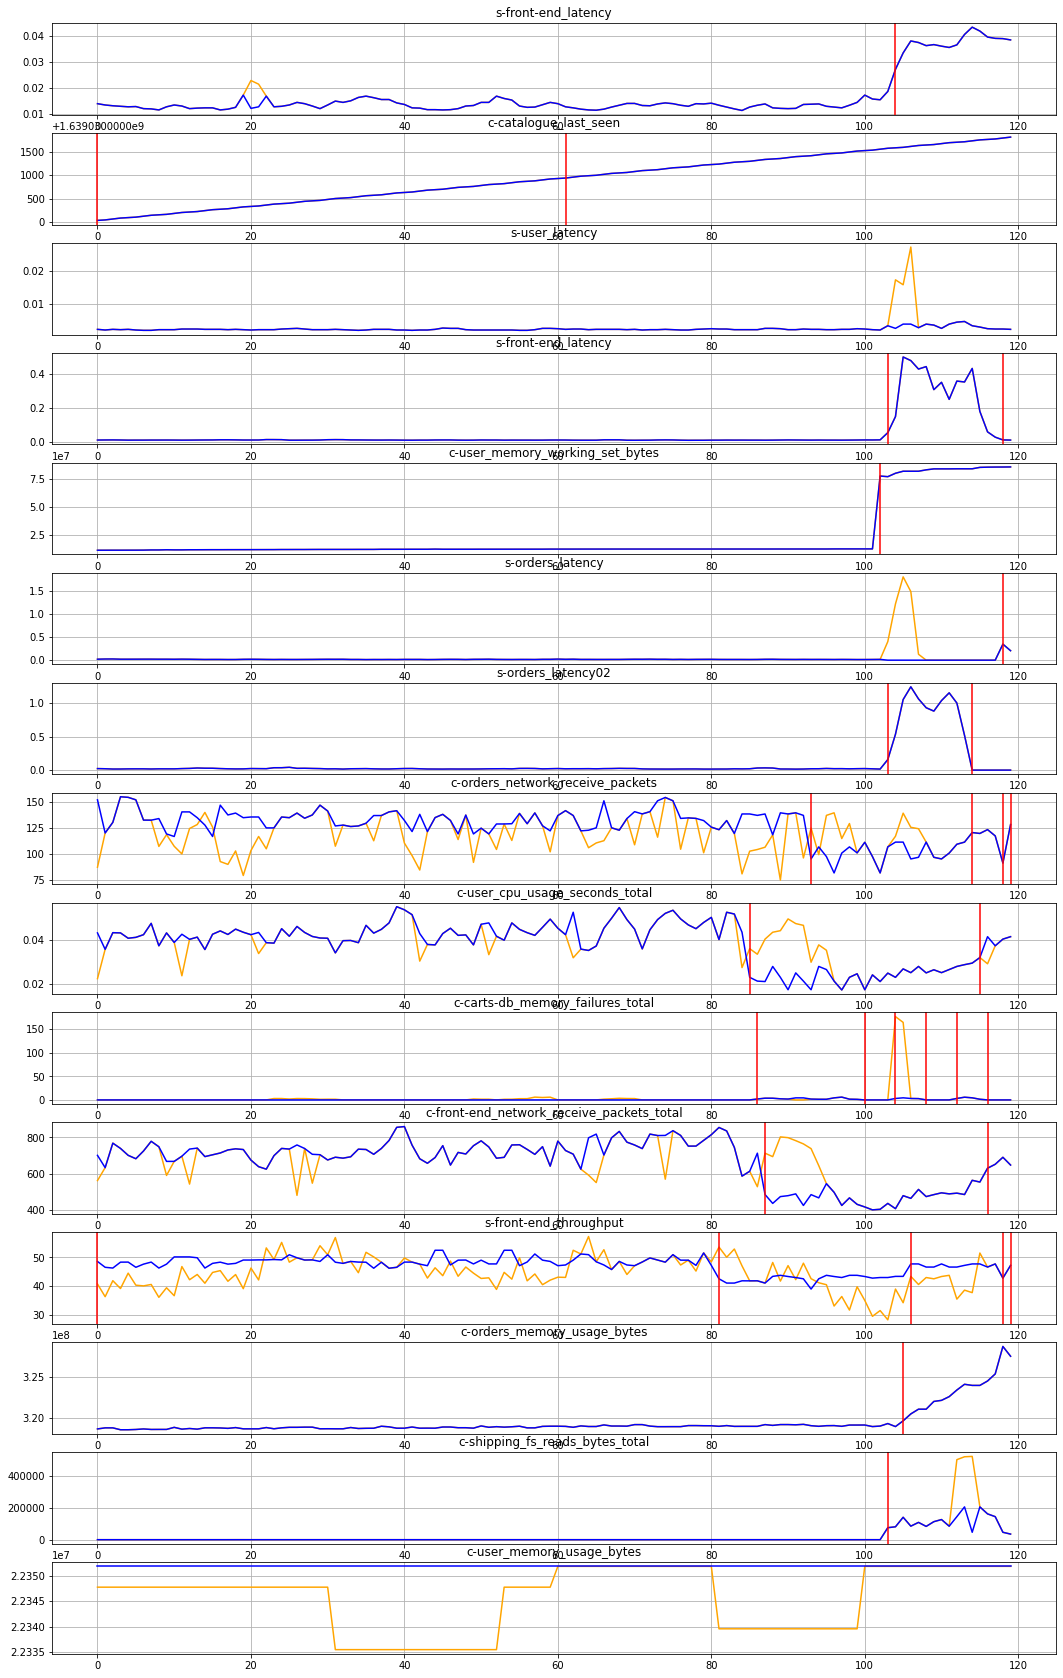

In [138]:
cases = sockshop.testcases_of_sockshop
fig, axs = plt.subplots(len(cases), ncols=1)
fig.set_size_inches(18, 2*len(cases))
for case, ax in zip(cases, axs.flatten()):
    # if case['name'] != 's-user_latency':
    #     continue
    ts = np.array(case['datapoints'])
    smoothed_x, segs, seg_bounds = fluxinfer_smooth(ts)
    ax.grid()
    ax.set_title(case['name'])
    ax.plot(case['datapoints'], color='orange')
    ax.plot(smoothed_x, color='blue')
    for bound in seg_bounds:
        ax.axvline(bound, color='r')